In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
import imblearn
import sklearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from xgboost import plot_importance
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Get Data

In [110]:
# read data
df = pd.read_csv("Assignment_1__bank-classification.csv")
# separate train and test set
df_train = df[df['y'] != 'unknown']
df_test = df[df['y'] == 'unknown']
# change train['y'] into numerical
df_train['y'] = df_train['y'].map({'no': 0, 'yes': 1})
combine = [df_train, df_test]

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


# Prelims

In [111]:
df.head()

,id,birth_date,job,marital,education,default,housing,loan,contact_date,contact,campaign,pdays,previous,poutcome,y
0,1,1952-03-23,housemaid,married,basic.4y,no,no,no,2008-05-12,telephone,1,999,0,nonexistent,no
1,2,1951-03-24,services,married,high.school,unknown,no,no,2008-05-26,telephone,1,999,0,nonexistent,unknown
2,3,1971-05-19,services,married,high.school,no,yes,no,2008-05-05,telephone,1,999,0,nonexistent,no
3,4,1968-01-24,admin.,married,basic.6y,no,no,no,2008-05-19,telephone,1,999,0,nonexistent,unknown
4,5,1952-05-11,services,married,high.school,no,no,yes,2008-05-19,telephone,1,999,0,nonexistent,unknown


In [112]:
# check shapes
print("train set shape = {}, test set shape = {}".format(df_train.shape, df_test.shape))
# check nulls
df.isnull().sum().sort_values(ascending=False)

train set shape = (20799, 15), test set shape = (20389, 15)


y               0
poutcome        0
previous        0
pdays           0
campaign        0
contact         0
contact_date    0
loan            0
housing         0
default         0
education       0
marital         0
job             0
birth_date      0
id              0
dtype: int64

#### Remarks:
* Dataset was collected from Portuguese retail bank from May 2008 to June 2013.
* There is no explicitly missing values in the set. All missing values are marked specifically for a feature, like 'nonexistent' or '999' or other.
* Lots of categorical data.
* Train and test sets are approx of equal size.

### Task description
#### Goal formulation
Our goal is to predict whether the client will subscribe a term deposit. This is a classification problem. Out target feature is 'y'. We are supposed to deliver the probabilities of deposit subscription so as to minimize AUC metric.
##### Train and test sets
Both train and test sets seem to be blended together. We are supposed to deliver predictions for the rows with target marked 'unknown'. All other rows form our train set.

### Domain knowledge
We want to predict if a person will make a term deposit. Basic question then is what factors may drive such decision. Theoretically, the following factors play the roles:
* __net cash available__: if I don't have any cash surplus, then I cannot make a depo at all
* __liquidity needs__: this is term deposit, so such decision frozens my cash for a while
* __income pattern__: I need to consider the expected cash flows within term depo time span to make a call
* __interest rate offered__ and __best market interest rate available__: the ultimate reward for postponing consumption, how good this offer is vs my alternative costs or relative to other banks offer
* all other __behavioral patterns__: do I even know what term deposit is? do I even care to have savings? how sophisticated is my analysis when making financial decisions? etc

Quick look at out feature set reveals that we lack any market-related data. The interest rate is one of the most crucial factor determining customers propensity to subscribe a depo. This may significantly hinder our prediction task.

### AUC metric

Puting:
$$ TPR(\tau) =  \frac{TP(\tau)}{N_{+}} \quad FPR(\tau) = \frac{FP(\tau)}{N_{-}}$$

where $\tau$ is a threshold in our decision rule $[f(x) > \tau]$. 

For some set $T$ we can plot $ TPR(\tau) $ vs $ FPR(\tau) $ for each $\tau \in T$. The area under this curve is AUC metric: the higher the better, min is 0, max is 1, for pure random AUC should ba approx. 0.5.

# First look at data
We now make a first inspection at the available data. We do not engineer them at this moment - all we want to do is to take a closer look to get more familiar with them, craft some intuition and draw some initial hints. But the feature engineering will be done after we complete this initial look iterations over all features.

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
id              41188 non-null int64
birth_date      41188 non-null object
job             41188 non-null object
marital         41188 non-null object
education       41188 non-null object
default         41188 non-null object
housing         41188 non-null object
loan            41188 non-null object
contact_date    41188 non-null object
contact         41188 non-null object
campaign        41188 non-null int64
pdays           41188 non-null int64
previous        41188 non-null int64
poutcome        41188 non-null object
y               41188 non-null object
dtypes: int64(4), object(11)
memory usage: 4.7+ MB


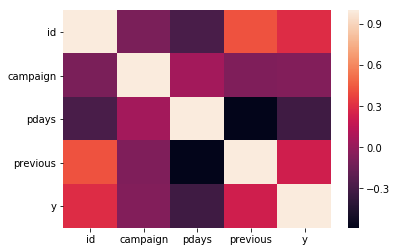

In [114]:
sns.heatmap(df_train.corr())

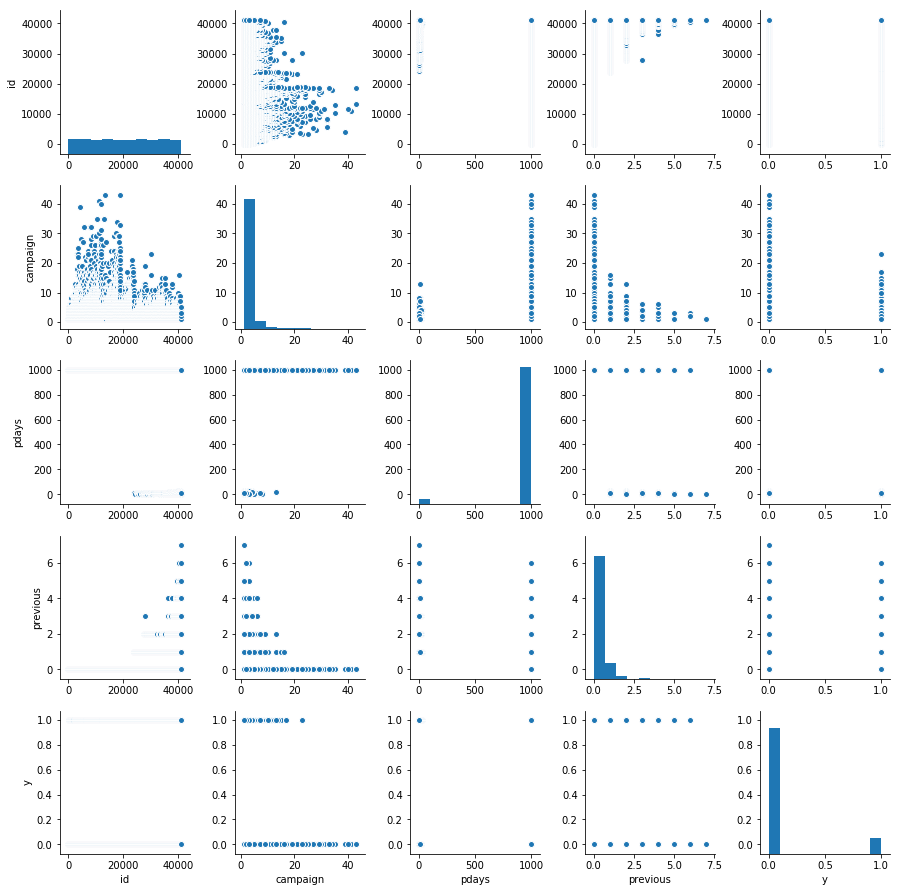

In [115]:
sns.pairplot(df_train,diag_kind='hist')

#### Remarks: 
* pair plot not especially helpful

### Target

In [116]:
# check target
df['y'].value_counts()

unknown    20389
no         18419
yes         2380
Name: y, dtype: int64

Text(0.5,1,u'Distribution of "y"')

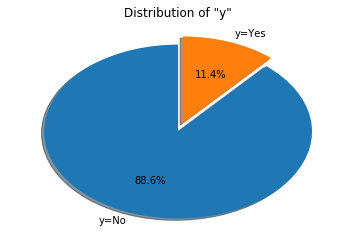

In [117]:
# "yes" vs "no" in training set
plt.pie([pd.value_counts(df_train['y'])[0], pd.value_counts(df_train['y'])[1]], 
        labels=["y=No", "y=Yes"], 
        startangle=90, 
        shadow=True, 
        explode=(0,0.1),
        autopct='%1.1f%%')
plt.title('Distribution of "y"')

#### Remarks:
* training set is highly imbalanced wrt target variable: this is problematic, esp that we want to do well on AUC.

### Birth date

In [118]:
print "The type of birth date is", type(df['birth_date'][0]) 
print "Date points span from", min(df['birth_date']), " to ", max(df['birth_date'])

The type of birth date is <type 'str'>
Date points span from 1912-01-17  to  1993-03-06


#### Remarks:
Exact birth dates seem not to be ideal representation. We may want to convert them into _age_. _Age_ seems to be an important factor for our target as it clearly determines the customer propensity to subscribing a deposit via both net weath (typically the older have more time to accumulate wealth) and behavioral patterns (which differ along the lifetime). Moreover, we may want to convert age into age bands.

### Job

In theory, this should be an important categorical feature determining income as well some behavioral finance patterns and we may want to convert it using one-hot encoding. There are 330 examples with 'unknown' jobs across all data 

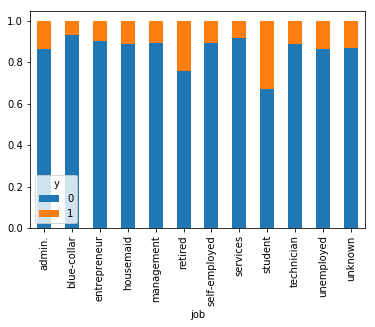

In [119]:
#Relative values
cross = pd.crosstab(df_train['job'], df_train['y'])
cross = cross.div(cross.sum(1).astype(float), axis=0)
cross.plot(kind='bar', stacked=True,grid=False)

#### Remarks:
* We have around 1% missing job data in both sets (sligthly more in train set, and slightly less in test set). This is rather small fraction 
* Retired people and students are relatively more keen to submit a depo ... bit surprising.

### Marital status

Marital status seems also to be important feature as it may give some insight into stability, risk aversion and other.

In [120]:
df['marital'].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

In [121]:
pd.value_counts(df_train['marital'])

married     12512
single       5896
divorced     2347
unknown        44
Name: marital, dtype: int64

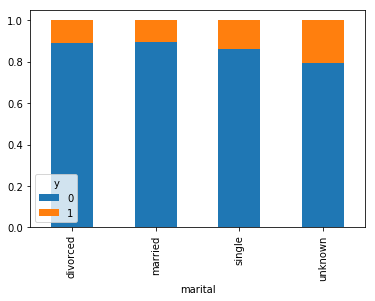

In [122]:
#Relative values
cross = pd.crosstab(df_train['marital'], df_train['y'])
cross = cross.div(cross.sum(1).astype(float), axis=0)
cross.plot(kind='bar', stacked=True,grid=False)

#### Remarks:
* married and divorced indicate against propensity to making depo - surprise surprise ;)

### Education

Education is somehow correlated with income and potentially behavioral patterns thus may affect our target - at least in theory.

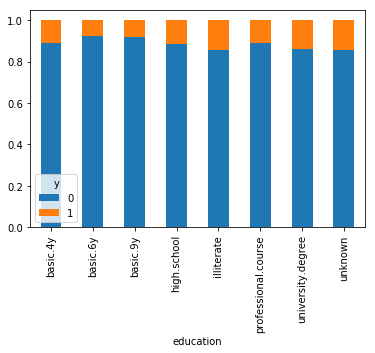

In [123]:
#Relative values
cross = pd.crosstab(df_train['education'], df_train['y'])
cross = cross.div(cross.sum(1).astype(float), axis=0)
cross.plot(kind='bar', stacked=True,grid=False)

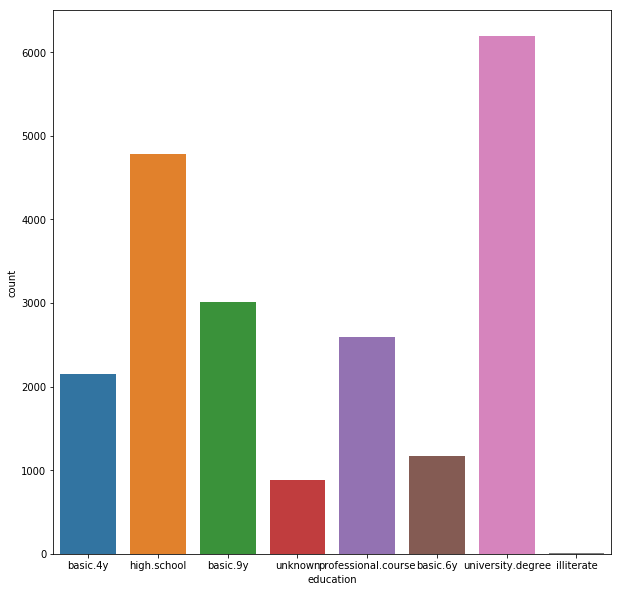

In [124]:
plt.figure(figsize=(10,10))
sns.countplot(x="education", data=df_train)

#### Remarks:
* some modest tendency to growing likelyhood of saying yes to deposit along increased quality of education
* with small exception for illiterate class ... but this is just noise
* might be wise to try to recombine into slightly less classes

### Default

This should a strong indicator against subscribing a depo as defaulted ones do not make deposits.

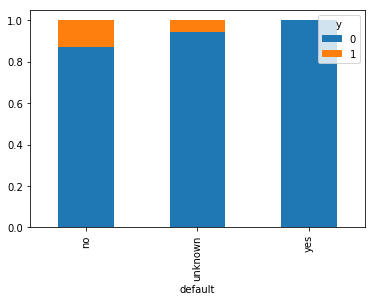

In [125]:
cross = pd.crosstab(df_train['default'], df_train.y)
cross = cross.div(cross.sum(1).astype(float), axis=0)
cross.plot(kind='bar', stacked=True,grid=False)

In [126]:
df_train['default'].value_counts()

no         16408
unknown     4389
yes            2
Name: default, dtype: int64

In [127]:
df_test['default'].value_counts()

no         16180
unknown     4208
yes            1
Name: default, dtype: int64

#### Remarks:
* our gut feeling was confirmed: default is strong indicator against making depo indeed
* sadly for us, only 3 customers are known to have defaulted
* we have a huge fraction of unknown data with slightly lower propensity to depo vs clear "no default" set ... most likely there are some defaulted but not labeled examples in "unknown"

### Housing

House loan usually constitutes a chunky part of one's overall debt. But this is a long-term debt and our deposit is defo a shorter term. Most likely it's mortgage loan with interest rate significantly lower than consumer loans. Thus it's not uncommon for a person to have both house loan and term depo. But still a housing loan payments may consume a siginificant part of one's income and in this way affect a depo decision.



### Loan
This feature states if one has a personal loan. Personal loans interest rate is defo higher than depo rate, otherwise I could earn risk-free money just by taking loan and puting it at higher depo rate driving such a merciful bank into bankruptcy. Puting it the other way round, theoritically having personal loan should be a strong indicator that the person will not subscribe a depo.

In [128]:
df.groupby(['loan', 'y']).size()

loan     y      
no       no         15161
         unknown    16828
         yes         1961
unknown  no           434
         unknown      500
         yes           56
yes      no          2824
         unknown     3061
         yes          363
dtype: int64

At least 363 people have both loan and deposit. This may be due to some irrationality of our examples agents or due to some very rare specific circumstances.


### Contact date

In [129]:
print "The type of contact date is", type(df['contact_date'][0])
print "Date points span from", min(df['contact_date']), " to ", max(df['contact_date'])

The type of contact date is <type 'str'>
Date points span from 2008-05-01  to  2010-11-30


#### Remarks:
I can't see a definition of this feature but most likely it is what it is - contact date :) If so, then this is really interesting: data has been collected over almost 2.5 year span period. This is a loong span, especially that 2008-2010 was THE bumpy ride. Forget about stationarity. And we have no underpinning of financial markets state along the way. Technically - let's convert it to days passed since contact.

### Contact

In [130]:
df['contact'].value_counts()

cellular     26144
telephone    15044
Name: contact, dtype: int64

### Campaign 

This is the number of contacts with a customer made in this campaign.

In [131]:
print "average # of contacts for hit = ", df.loc[df['y'] == 'yes']['campaign'].mean()
print "average # of contacts for miss = ", df.loc[df['y'] == 'no']['campaign'].mean()
print "average # of contact in train data = ", df.loc[df['y'] != 'unknown']['campaign'].mean()
print "average # of contact in test data = ", df.loc[df['y'] == 'unknown']['campaign'].mean()

average # of contacts for hit =  2.09621848739
average # of contacts for miss =  2.64379173679
average # of contact in train data =  2.58113370835
average # of contact in test data =  2.55377899848


#### Remarks:
On average, 2 calls were sufficient to strike a deal. We can see there was some kind of sales push if 2 calls were not enough.

### Pdays
"number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)"

### Previous
number of contacts performed before this campaign and for this client (numeric)

#### Remarks:
We don't have information of what kind that previous campaign was. But if this was unrelated to current sale, still it might be valueable information as it may give some hints about susceptibility to sales persuasion/marketing efforts. Obvious one-hot encoding candidate.

### Poutcome
outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

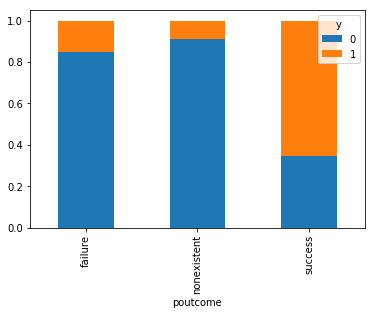

In [132]:
cross = pd.crosstab(df_train['poutcome'], df_train.y)
cross = cross.div(cross.sum(1).astype(float), axis=0)
cross.plot(kind='bar', stacked=True,grid=False)

# Feature engineering

#### Age

In [133]:
# birth date into age
cutoff_year = 2018
for el in combine:
    el.rename(columns={'birth_date': 'age'}, inplace=True)
    el['age'] = [cutoff_year - int(s[0:4]) for s in el['age']]

# convert age into bins
bins = [0,30,35,40,45,50,55,60, 65, 70, np.inf]
labels=['age_30', 'age_35', 'age_40', 'age_45', 'age_50', 'age_55', 'age_60', 'age_65', 
       'age_70', 'age_70+']
for df in combine:
    df['age_band'] = pd.cut(df['age'], bins=bins, labels=labels)

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


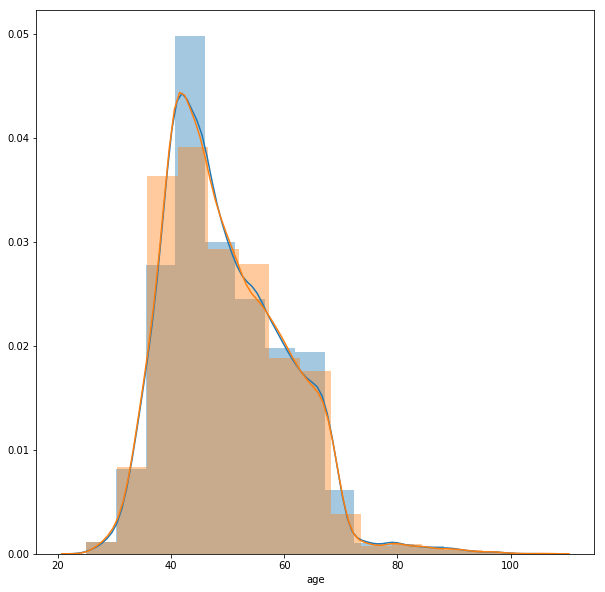

In [134]:
plt.figure(figsize=(10,10))
n_bins = 15
sns.distplot(df_train['age'], bins=n_bins)
sns.distplot(df_test['age'], bins=n_bins)

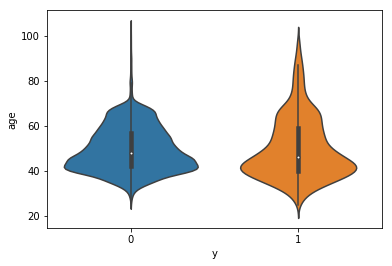

In [135]:
sns.violinplot(y=df_train["age"], x=df_train["y"])

#### Remarks:
* there is some interesting flattening around mid years in test vs train set
* there is interesting long tail on "the elder" side among those who subscribed depo 

#### Education

In [136]:
# combine basic
for df in combine:
    df['education'] = df['education'].replace(['basic.6y', 'basic.9y', 'basic.4y', 
                                               'illiterate'], 'basic')
# combine higher
for df in combine:
    df['education'] = df['education'].replace(['high.school', 'professional.course'], 
                                              'higher')

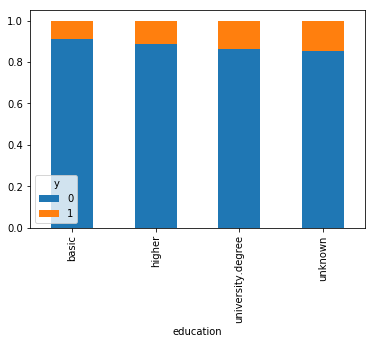

In [137]:
#Relative values
cross = pd.crosstab(df_train['education'], df_train['y'])
cross = cross.div(cross.sum(1).astype(float), axis=0)
cross.plot(kind='bar', stacked=True,grid=False)

#### Campaign

In [138]:
# convert campaign into bins
bins = [0,1,2,3,4,5,6,np.inf]
labels=['camp_1', 'camp_2', 'camp_3', 'camp_4', 'camp_5', 'camp_6', 'camp_7+']
for df in combine:
    df['campaign_band'] = pd.cut(df['campaign'], bins=bins, labels=labels)

#### Contact days

In [139]:
# contact days
combine = [df_train, df_test]
date0=pd.to_datetime('2014-01-01', format='%Y-%m-%d')

for df in combine:
    df.rename(columns={'contact_date': 'contact_days_ago'}, inplace=True)
    df['contact_days_ago'] = (date0 - pd.to_datetime(df['contact_days_ago'])).dt.days

# centralize a bit
for df in combine:
    df['contact_days_ago'] = df['contact_days_ago'] - 1128

# create labels for bins (default labels not good for xgb)
n_bins = 10
label_pref = "days_ago_band_"
labels = []
for i in range(n_bins):
    label = label_pref + str(i)
    labels.append(label)
    
for df in combine:
    df['contact_days_band'] = pd.cut(df['contact_days_ago'], bins=n_bins, labels=labels)

#### Pdays

In [140]:
# pdays
for df in combine:
    df['first_time'] = df['pdays'] == 999

### Droping columns and hot encoding

In [141]:
# drop redundant columns
columns_to_drop_0 = ['age', 'contact_days_ago', 'pdays', 'campaign']
df_train = df_train.drop(columns_to_drop_0, axis = 1)
df_test = df_test.drop(columns_to_drop_0, axis = 1)

# hot encoding categorical data
hot_features_0 = ['job', 'marital', 'education', 'default', 
                'housing', 'loan', 'contact', 'poutcome', 
                  'age_band','campaign_band', 'contact_days_band']
df_train = pd.get_dummies(df_train, columns=hot_features_0)
df_test = pd.get_dummies(df_test, columns=hot_features_0)

### Get X, y and train/dev split

In [142]:
X = df_train.drop(['y', 'id'], axis = 'columns')
y = df_train['y']

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2)

In [143]:
df_train.shape

(20799, 65)

In [144]:
df_test.shape

(20389, 65)

In [145]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20799 entries, 0 to 41187
Data columns (total 65 columns):
id                                   20799 non-null int64
previous                             20799 non-null int64
y                                    20799 non-null int64
first_time                           20799 non-null bool
job_admin.                           20799 non-null uint8
job_blue-collar                      20799 non-null uint8
job_entrepreneur                     20799 non-null uint8
job_housemaid                        20799 non-null uint8
job_management                       20799 non-null uint8
job_retired                          20799 non-null uint8
job_self-employed                    20799 non-null uint8
job_services                         20799 non-null uint8
job_student                          20799 non-null uint8
job_technician                       20799 non-null uint8
job_unemployed                       20799 non-null uint8
job_unknown           

## Balancing

To balance the data, we can either undersample (delete the instances from over-represented class) or oversample (add copies of instances from the under-represented class)

### Undersampling 

In [148]:
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X_train, y_train)

### Oversampling with SMOTE

In [147]:
sm = SMOTE()
X_sm, y_sm = sm.fit_resample(X_train, y_train)

/usr/lib64/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


In [150]:
# Random Forest with SMOTE
estim_set = {10, 20, 30, 40, 50, 70, 100, 125, 150, 200, 250}
depth_set = {2, 4, 6, 8, 10, 20}
yhat_probs = {}
auc_scores = {}
for e in estim_set:
    for d in depth_set:
        rf = RandomForestClassifier(n_estimators=e, max_depth=d, random_state=0)
        rf.fit(X_sm, y_sm)
        yhat_probs['train'] = rf.predict_proba(X_train)[:,1]
        yhat_probs['dev'] = rf.predict_proba(X_dev)[:,1]
        auc_scores['dev'] = roc_auc_score(y_dev, yhat_probs['dev'])
        auc_scores['train'] = roc_auc_score(y_train, yhat_probs['train'])
        print("# of estimator = {}, # of depths = {}".format(e, d))
        print(auc_scores)

# of estimator = 100, # of depths = 2
{'train': 0.75748610007508987, 'dev': 0.7678664332850984}
# of estimator = 100, # of depths = 4
{'train': 0.77344486044509619, 'dev': 0.77610508700203695}
# of estimator = 100, # of depths = 6
{'train': 0.7889962013753874, 'dev': 0.78333428118266313}
# of estimator = 100, # of depths = 8
{'train': 0.80540299932658732, 'dev': 0.78406833783035179}
# of estimator = 100, # of depths = 10
{'train': 0.82892632870479521, 'dev': 0.78344854968520883}
# of estimator = 100, # of depths = 20
{'train': 0.95787472702460585, 'dev': 0.77646211024962142}
# of estimator = 70, # of depths = 2
{'train': 0.75497259995940724, 'dev': 0.76519244500894135}
# of estimator = 70, # of depths = 4
{'train': 0.77269286953715133, 'dev': 0.77578782076801067}
# of estimator = 70, # of depths = 6
{'train': 0.78861374270302642, 'dev': 0.7819575300310263}
# of estimator = 70, # of depths = 8
{'train': 0.80479365437941497, 'dev': 0.78356703085144253}
# of estimator = 70, # of depths = 

In [152]:
# Random Forest with RandomUnderSampler
estim_set = {10, 20, 30, 40, 50, 70, 100, 125, 150, 200, 250, 300, 350, 500}
depth_set = {2, 4, 6, 8, 10, 20}
yhat_probs = {}
auc_scores = {}
for e in estim_set:
    for d in depth_set:
        rf = RandomForestClassifier(n_estimators=e, max_depth=d, random_state=0)
        rf.fit(X_rus, y_rus)
        yhat_probs['train'] = rf.predict_proba(X_train)[:,1]
        yhat_probs['dev'] = rf.predict_proba(X_dev)[:,1]
        auc_scores['dev'] = roc_auc_score(y_dev, yhat_probs['dev'])
        auc_scores['train'] = roc_auc_score(y_train, yhat_probs['train'])
        print("# of estimator = {}, # of depths = {}".format(e, d))
        print(auc_scores)

# of estimator = 100, # of depths = 2
{'train': 0.75720987486553781, 'dev': 0.7666447608154876}
# of estimator = 100, # of depths = 4
{'train': 0.77277153873900173, 'dev': 0.77687890066328391}
# of estimator = 100, # of depths = 6
{'train': 0.79157748335602918, 'dev': 0.78549616752920959}
# of estimator = 100, # of depths = 8
{'train': 0.81231137870898618, 'dev': 0.78962431465227623}
# of estimator = 100, # of depths = 10
{'train': 0.83302861534412465, 'dev': 0.79023857367632833}
# of estimator = 100, # of depths = 20
{'train': 0.93469454902720739, 'dev': 0.7735985521074904}
# of estimator = 70, # of depths = 2
{'train': 0.75578377938279218, 'dev': 0.76622059824037037}
# of estimator = 70, # of depths = 4
{'train': 0.7703542404429391, 'dev': 0.77522622004006236}
# of estimator = 70, # of depths = 6
{'train': 0.78882480774747266, 'dev': 0.78414469235970252}
# of estimator = 70, # of depths = 8
{'train': 0.81179799890019688, 'dev': 0.78998449739762688}
# of estimator = 70, # of depths = 

## XGB

In [159]:
# xgb with rus
estim_set = {10, 20, 30, 40, 50, 70, 100, 125, 150, 200, 250, 300, 350, 500}
depth_set = {2, 4, 6, 8, 10, 20}
yhat_probs = {}
auc_scores = {}
X_train_matrix = X_train.as_matrix()
X_dev_matrix = X_dev.as_matrix()
for e in estim_set:
    for d in depth_set:
        xgb_model = xgb.XGBClassifier(n_estimators=e, max_depth=d, learning_rate=0.1, subsample=0.5)
        xgb_model.fit(X_rus, y_rus, eval_metric='auc')
        yhat_probs['train'] = xgb_model.predict_proba(X_train_matrix)[:,1]
        yhat_probs['dev'] = xgb_model.predict_proba(X_dev_matrix)[:,1]
        auc_scores['dev'] = roc_auc_score(y_dev, yhat_probs['dev'])
        auc_scores['train'] = roc_auc_score(y_train, yhat_probs['train'])
        print("# of estimator = {}, # of depths = {}".format(e, d))
        print(auc_scores)

# of estimator = 100, # of depths = 2
{'train': 0.7884071563958297, 'dev': 0.78904770630993837}
# of estimator = 100, # of depths = 4
{'train': 0.81255958450135535, 'dev': 0.78426975581294922}
# of estimator = 100, # of depths = 6
{'train': 0.84258434718472031, 'dev': 0.77651476854572532}
# of estimator = 100, # of depths = 8
{'train': 0.86349693687143381, 'dev': 0.77244375567393142}


KeyboardInterrupt: 

## Sub

In [155]:
rus = RandomUnderSampler(return_indices=True)
X_rus_all, y_rus_all, id_rus = rus.fit_sample(X, y)

In [156]:
rf = RandomForestClassifier(n_estimators=250, max_depth=10, random_state=0)
rf.fit(X_rus_all, y_rus_all)
X_test = df_test.drop(['y', 'id'], axis = 'columns')
ypred = rf.predict_proba(X_test)[:, 1]

In [157]:
df_sub_1 = df_test[['id']].copy()
df_sub_1['y']=ypred
df_sub_1.to_csv('df_sub_6_rf_rus.csv', index=False)

In [160]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=2, learning_rate=0.1, subsample=0.5)
xgb_model.fit(X_rus, y_rus, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

In [161]:
ypred = rf.predict_proba(X_test)[:, 1]

In [162]:
df_sub_1 = df_test[['id']].copy()
df_sub_1['y']=ypred
df_sub_1.to_csv('df_sub_7_xgb_rus.csv', index=False)